## Gerchberg and Saxton's original algorithm for phase retrieval
_Paper: Gerchberg and Saxton, Optik, 35, 237–246, 1972. [link](http://www.u.arizona.edu/~ppoon/GerchbergandSaxton1972.pdf)_

In [27]:
%%capture
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
exec(open('../codes/zernike.py'))
exec(open('../codes/util.py'))
%matplotlib inline

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

In [28]:
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import numpy as np

def GS_two_img(pupil,focus,threshold=5e-3,init='random'):
    """
    Assume that both pupil and focus plane images are sized with
    the same circular aperture.
    """
    ## intensity to amplitude
    pup,foc = np.sqrt(pupil),np.sqrt(focus)
    
    ## initialize error and phase
    err = 1e10
    if init=='random':
        pha = fullcmask(np.random.random(pup.shape) * 2*np.pi)
    elif init=='uniform':
        pha = fullcmask(np.ones(pup.shape))
    else:
        raise NameError('No such choice. Use "random" or "uniform"')
    
    ## initial states
    plt.figure(figsize=(16,8))
    plt.subplot(121); plt.imshow(pup,origin='lower')
    plt.title('Input Amplitude')
    plt.subplot(122); plt.imshow(pha,origin='lower')
    plt.title('Initial Phase'); plt.show()
    
    ##
    i = 1
    pup_sum = np.sum(pup)
    
    err_list = []
    while err > threshold:
        Fpup = fullcmask(fftshift(fft2(pup*np.exp(1j*pha))))
        pha  = fullcmask(np.arctan2(Fpup.imag,Fpup.real))
        Ifoc = fullcmask(ifft2(ifftshift(foc*np.exp(1j*pha))))
        pha  = fullcmask(np.arctan2(Ifoc.imag,Ifoc.real))
        
        #plt.imshow(abs(Ifoc)); plt.show()
        ## error (intensity) computed in pupil plane
        #-- defined as rms error / sum of true input image
        err =  np.sqrt(np.sum((abs(Ifoc)-pup)**2)) / pup_sum
        i += 1
        if i%50==0:
            print 'Current step : {0}'.format(i)
            print '        Error: {0:.2e}'.format(err)
        
        err_list.append(err)
        ## if stuck, then stop
        #if np.std(err_list[:-30]) < threshold/100:
        #    break
        if i >= 500:
            break
            
    print 'Final step : {0}'.format(i)
    print 'Final Error: {0:.2e}'.format(err)
        
    return abs(Ifoc),pha

### Input

In [29]:
Npix = 256
## TRUE inputs
zer  = Zernike(Z3=0.6,Z4=1,Z8=2,Npix=Npix)
zerr = Zernike(Z2=0.8,Z3=0.5,Z6=0.6,Npix=Npix)
#zer  = Zernike(Z3=0.6,Npix=Npix)
#zerr = Zernike(Z2=0.8,Npix=Npix)
Aamp = abs(zer.crCartAber(plot=False))
Apha = zerr.crCartAber(plot=False)

A_ = Aamp*np.exp(1j*Apha)
A = abs(A_)**2

## TRUE image
B_rec = np.fft.fftshift(np.fft.fft2(A_))
B_ = fullcmask(B_rec)
Bamp = abs(B_)
Bpha = np.arctan2(B_.imag,B_.real)
B = Bamp**2

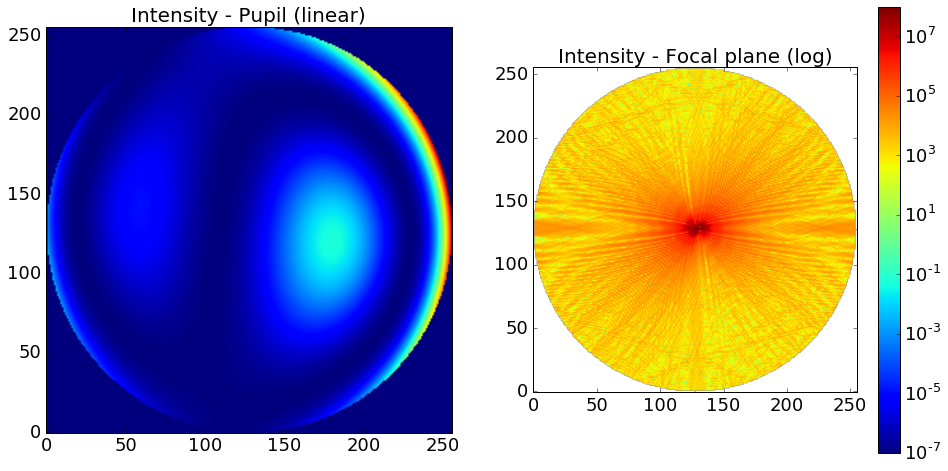

In [6]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(A,origin='lower')
plt.title('Intensity - Pupil (linear)')
plt.subplot(122); plt.imshow(B,origin='lower',norm=LogNorm())
plt.title('Intensity - Focal plane (log)')
plt.colorbar(); plt.clim(1e-7,1e8)

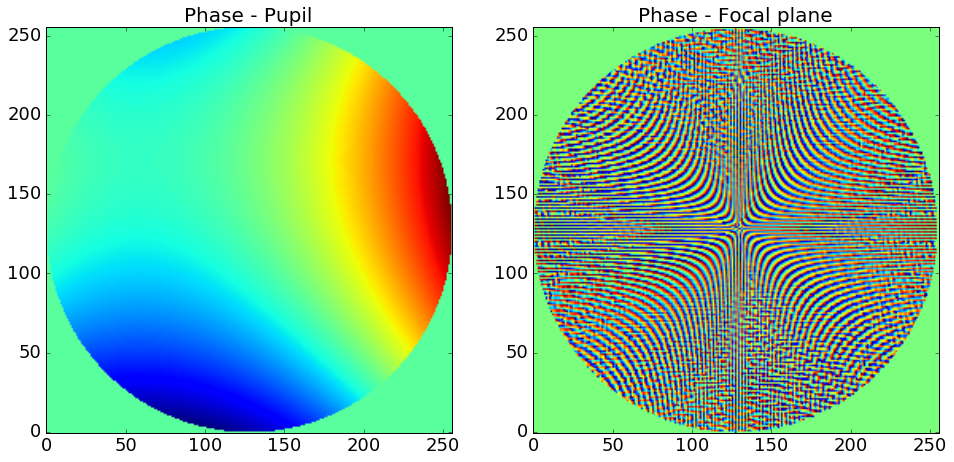

In [7]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(Apha,origin='lower')
plt.title('Phase - Pupil')
plt.subplot(122); plt.imshow(Bpha,origin='lower')
plt.title('Phase - Focal plane')

### FT and then IFT
Even within one loop (forward and backward transformations), the computer has introduced some artifacts into the phase...

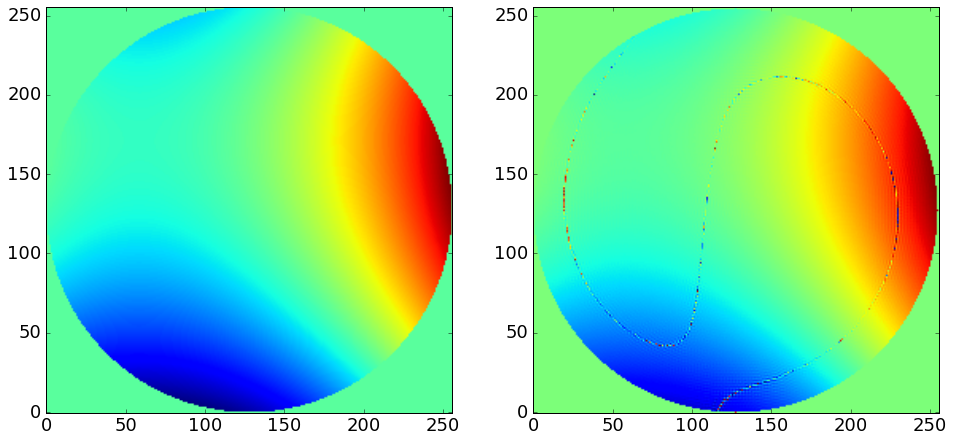

In [8]:
A_if = np.fft.ifft2(np.fft.ifftshift(B_))
A_ifAmp = abs(A_if)
A_ifPha = np.arctan2(A_if.imag,A_if.real)

plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(Apha,origin='lower')
plt.subplot(122); plt.imshow(cmask(A_ifPha),origin='lower'); 

** Absolute difference **

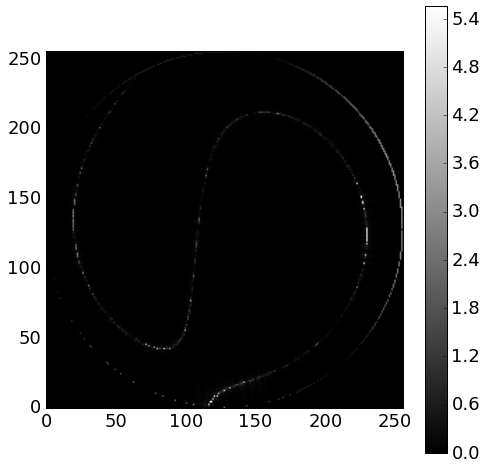

In [181]:
plt.figure(figsize=(8,8))
plt.imshow(abs(Apha-cmask(A_ifPha)),origin='lower',cmap='gray')
plt.colorbar()

---
### GS test run...

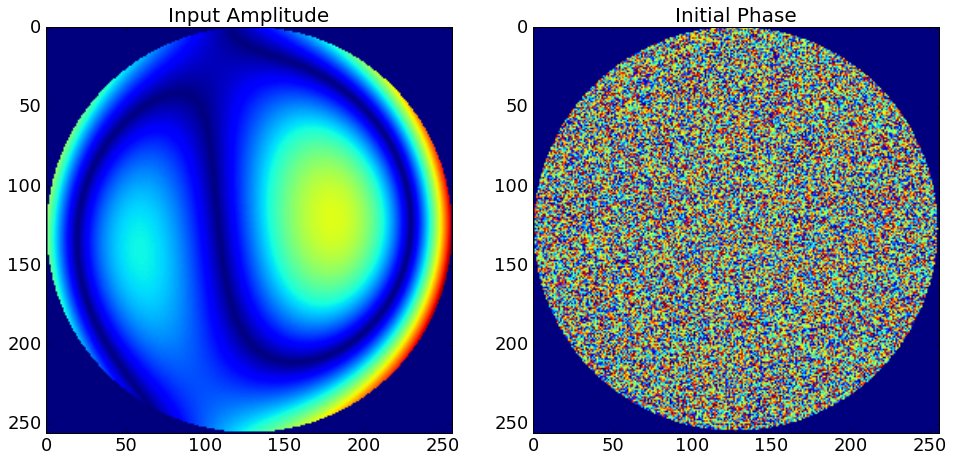

Current step : 50
        Error: 1.27e-03
Current step : 100
        Error: 1.24e-03
Current step : 150
        Error: 1.24e-03
Current step : 200
        Error: 1.23e-03
Current step : 250
        Error: 1.23e-03
Current step : 300
        Error: 1.23e-03
Current step : 350
        Error: 1.23e-03
Current step : 400
        Error: 1.23e-03
Current step : 450
        Error: 1.23e-03
Current step : 500
        Error: 1.23e-03
Final step : 500
Final Error: 1.23e-03


In [18]:
ret_amp,ret_pha = GS_two_img(A,B,threshold=1e-3)

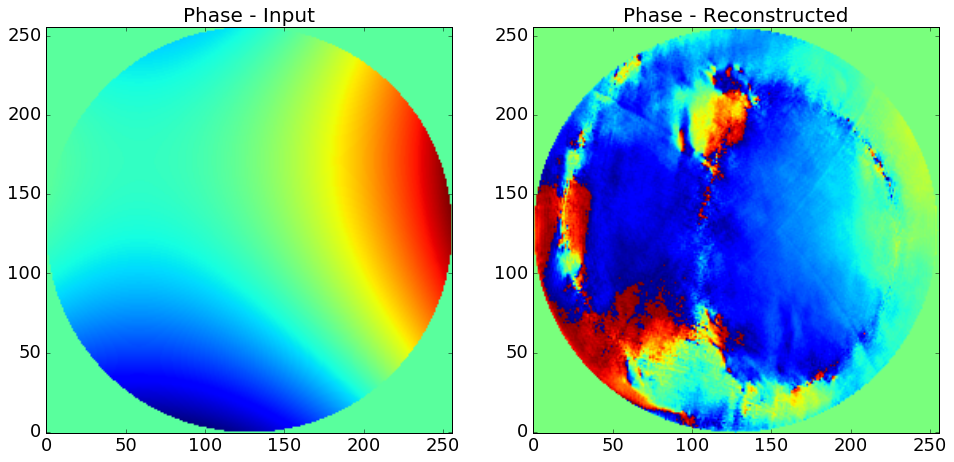

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(Apha,origin='lower')
plt.title('Phase - Input')
plt.subplot(122); plt.imshow(ret_pha,origin='lower')
plt.title('Phase - Reconstructed')

It is quite unsatisfactory...

rms residual error (in phase) = 4.97e+02


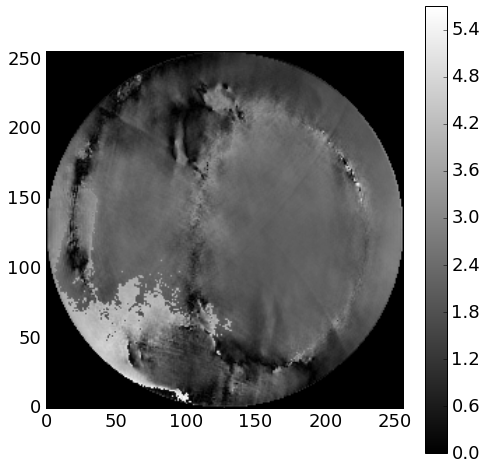

In [20]:
res_pha = Apha-ret_pha

plt.figure(figsize=(8,8))
plt.imshow(abs(res_pha),origin='lower',cmap='gray')
plt.colorbar()
print 'rms residual error (in phase) = {0:.2e}'.format(np.sqrt(np.sum(res_pha**2)))

One issue of the simplist GS algorithm is of course "gettisg stuck in local minimum". Evidently, every single run often renders quite different "reconstructed" phase (see below). But of course the intensity got recovered pretty well:

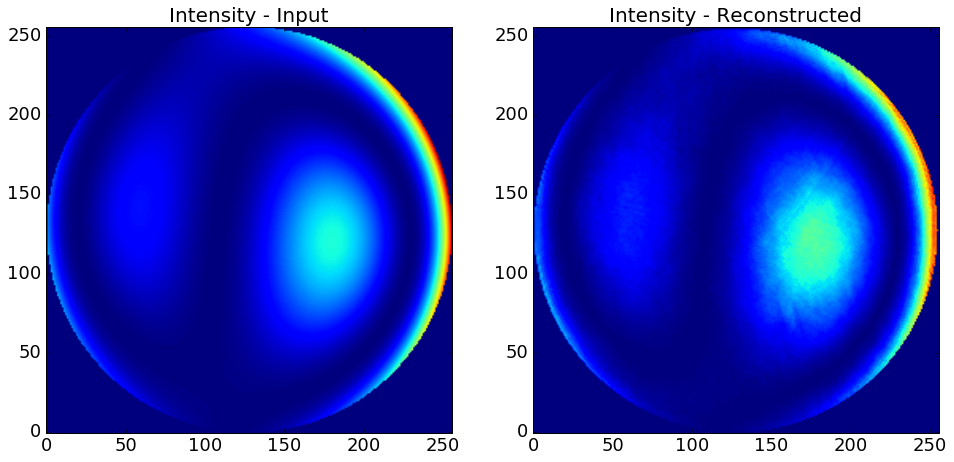

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(A,origin='lower')
plt.title('Intensity - Input')
plt.subplot(122); plt.imshow(abs(ret_amp*np.exp(1j*ret_pha))**2,origin='lower')
plt.title('Intensity - Reconstructed')

---
### Another run, with uniform initial phase guess

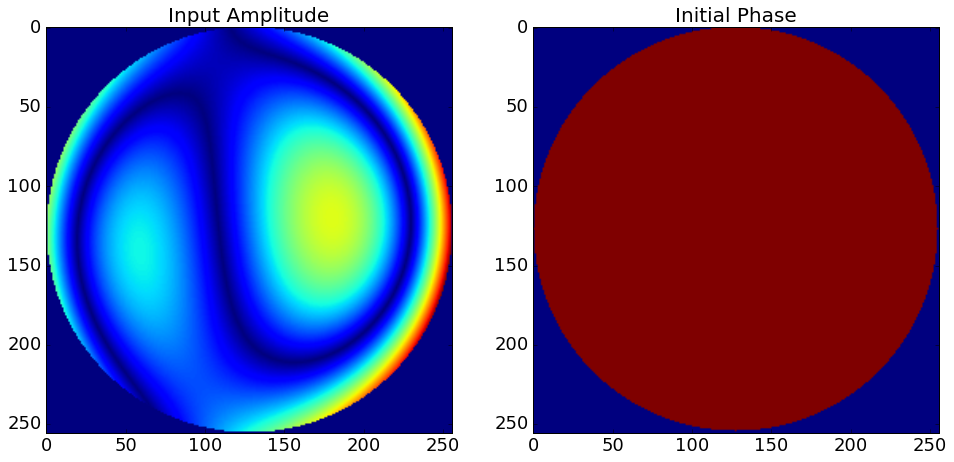

Current step : 50
        Error: 1.46e-03
Current step : 100
        Error: 1.41e-03
Current step : 150
        Error: 1.40e-03
Current step : 200
        Error: 1.40e-03
Current step : 250
        Error: 1.39e-03
Current step : 300
        Error: 1.39e-03
Current step : 350
        Error: 1.39e-03
Current step : 400
        Error: 1.39e-03
Current step : 450
        Error: 1.39e-03
Current step : 500
        Error: 1.39e-03
Final step : 500
Final Error: 1.39e-03


In [23]:
reu_amp,reu_pha = GS_two_img(A,B,threshold=1e-3,init='uniform')

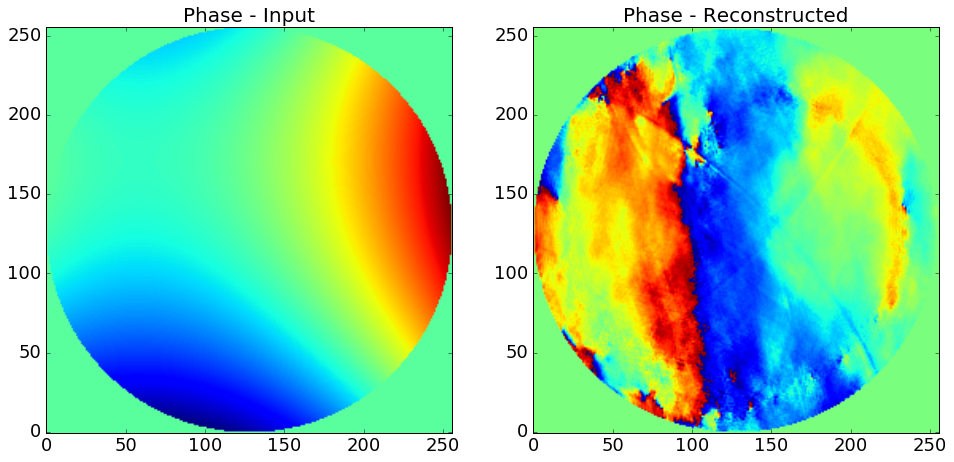

In [25]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(Apha,origin='lower')
plt.title('Phase - Input')
plt.subplot(122); plt.imshow(reu_pha,origin='lower')
plt.title('Phase - Reconstructed')

rms residual error (in phase) = 4.97e+02


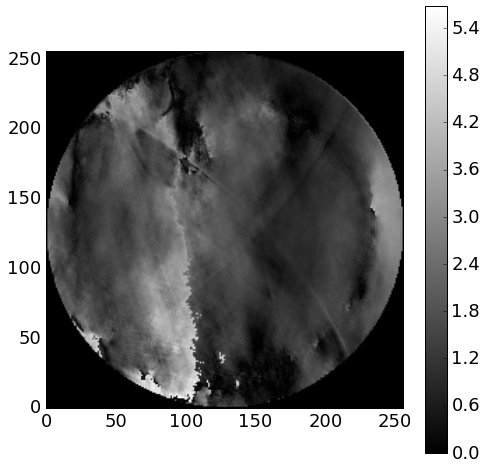

In [26]:
reus_pha = Apha-reu_pha

plt.figure(figsize=(8,8))
plt.imshow(abs(reus_pha),origin='lower',cmap='gray')
plt.colorbar()
print 'rms residual error (in phase) = {0:.2e}'.format(np.sqrt(np.sum(res_pha**2)))